In [1]:
# Modified version of the PSTH script with flexible comparison groups

from os.path import join
import pandas as pd
from src import TDT_experiment as tdt
import parse_cleanup_file
parse_cleanup_file.main()
import metadata
import matplotlib.pyplot as plt
import os
from pathlib import Path


Number of trials in each group:
Young CtxA Day1: 5
Old CtxA Day1: 4


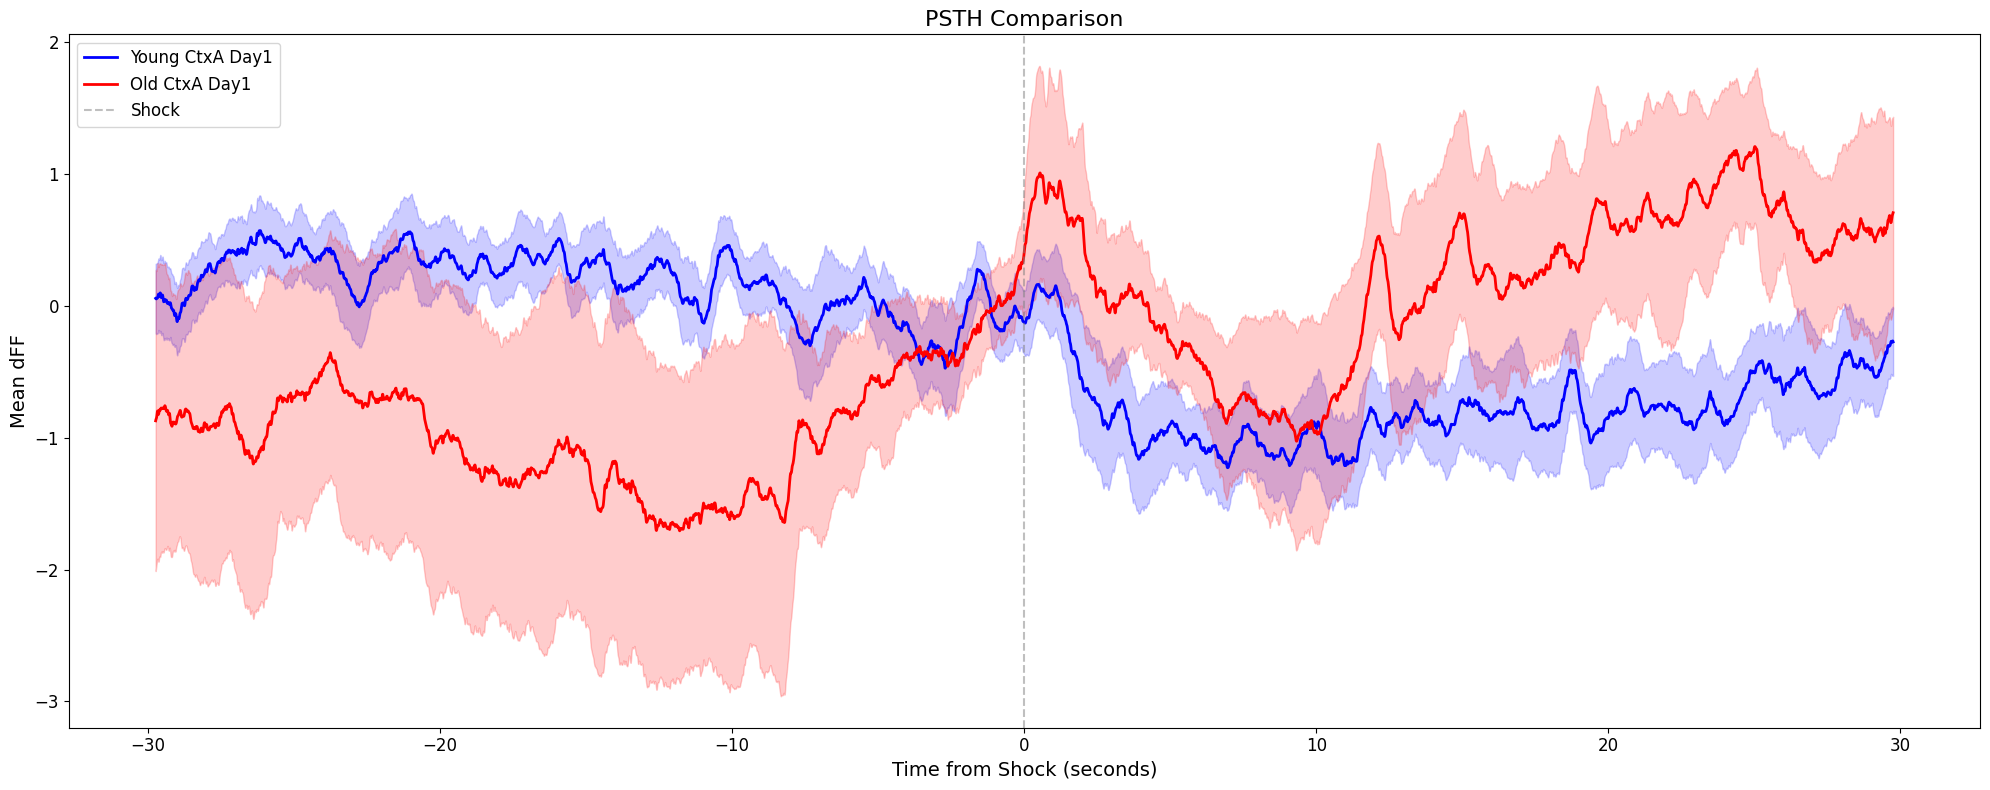

In [12]:
def df_type_annotation(df: pd.DataFrame) -> pd.DataFrame:
    df["Frame"] = df["Frame"].astype(int)
    df["Shock"] = df["Shock"].astype(int)
    df["dFF"] = df["dFF"].astype(float)
    df["Freezing"] = df["Freezing"].astype(int)
    return df

def parse_mouse_id(series: pd.Series) -> pd.Series:
    series = series.str.split("_", expand=True)
    return series[0] + "_" + series[1]

def get_day_data(folder_name):
    exp = tdt.TDTExperiment(join(metadata.ROOT_DATA_DIR, folder_name))
    fiber_df = pd.read_csv(join(exp.analysis_path, "fiber_freezing_output.csv"))
    df_annot = df_type_annotation(fiber_df)
    df_annot["mouse_id"] = parse_mouse_id(df_annot["Mouse ID"])
    day_data = df_annot[["mouse_id", "dFF", "Shock"]]
    return day_data

def process_all_data(day_df):
    all_data = []
    for folder_name in day_df["Folder Name"]:
        result_df = get_day_data(folder_name)
        all_data.append(result_df)
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

def get_group_data(df, context, day_number, age_group=None):
    """
    Get data for a specific experimental group
    
    Parameters:
    df: pandas DataFrame with metadata
    context: str, context to analyze (e.g., 'A', 'B')
    day_number: int, day to analyze (e.g., 1, 2, 3)
    age_group: str, optional, age group to filter ('Young' or 'Old')
    """
    context_str = f"cxt{context.lower()}"
    day_str = f"day_{day_number}"
    
    # Filter data
    mask = (df["context"] == context_str) & (df["day"] == day_str)
    if age_group:
        mask = mask & (df["Age (binary)"] == age_group)
    
    group_df = df[mask].reset_index(drop=True)
    return group_df

def generate_flexible_psth(group_configs, colors=None, labels=None):
    """
    Generate PSTH comparing any two or more experimental groups
    
    Parameters:
    group_configs: list of dicts, each containing:
        - context: str, context to analyze (e.g., 'A', 'B')
        - day: int, day to analyze (e.g., 1, 2)
        - age_group: str, optional, age group to filter ('Young' or 'Old')
    colors: list of colors for plotting (defaults to ['blue', 'red', 'green', 'purple'])
    labels: list of legend labels (defaults to auto-generated labels)
    """
    # Default colors if none provided
    if colors is None:
        colors = ['blue', 'red', 'green', 'purple']
    
    # Read metadata
    df = pd.read_excel(metadata.GOOD_METADATA)
    
    # Process each group
    group_trials = []
    auto_labels = []
    
    for config in group_configs:
        context = config['context']
        day = config['day']
        age_group = config.get('age_group', None)  # Optional
        
        # Get data for this group
        group_df = get_group_data(df, context, day, age_group)
        if group_df.empty:
            raise ValueError(f"No data found for context {context}, day {day}, age {age_group}")
            
        all_data = process_all_data(group_df)
        
        # Create automatic label if none provided
        group_label = f"Ctx{context} Day{day}"
        if age_group:
            group_label = f"{age_group} {group_label}"
        auto_labels.append(group_label)
        
    # CONFIGURABLE: Time window around shock (in number of rows)
    # With current frame rate (101.7 Hz), 3050 frames ≈ 30 seconds
        trials = []
        pre_shock = 3050
        post_shock = 3050
        
        for trial_id, trial_df in all_data.groupby("mouse_id"):
            shock_indices = trial_df[trial_df["Shock"] == 100].index
            
            if len(shock_indices) != 1:
                print(f"Skipped: Multiple or no shock indices")
                continue
                
            shock_idx = shock_indices[0]
            start_idx = shock_idx - pre_shock
            end_idx = shock_idx + post_shock
            
            if start_idx < trial_df.index.min() or end_idx > trial_df.index.max():
                continue
                
            window_df = trial_df.loc[start_idx:end_idx].copy()
            window_df["time_from_shock"] = window_df.index - shock_idx
            
            # CONFIGURABLE: Baseline normalization
            # Current settings: normalizes to 2 seconds pre-shock
            seconds_to_frames = 1/0.00983123054  # frame rate conversion factor
            baseline_window = 2  # seconds before shock for baseline
            baseline_mask = (window_df.index >= shock_idx - (baseline_window * seconds_to_frames)) & (window_df.index < shock_idx)
            baseline_mean = window_df.loc[baseline_mask, "dFF"].mean()
            window_df["dFF"] = window_df["dFF"] - baseline_mean
            
            trials.append(window_df[["time_from_shock", "dFF"]])
        
        group_trials.append(trials)
    
    # Use provided labels if available, otherwise use auto-generated
    if labels is None:
        labels = auto_labels
    
    # Plotting
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    
    frames_to_seconds = 0.00983123054
    window_size = 50
    
    # Plot each group
    for i, (trials, color, label) in enumerate(zip(group_trials, colors, labels)):
        if not trials:
            continue
            
        group_df = pd.concat(trials, ignore_index=True)
        psth = group_df.groupby("time_from_shock")["dFF"].mean().reset_index()
        sem = group_df.groupby("time_from_shock")["dFF"].sem().reset_index()
        
        smooth = psth["dFF"].rolling(window=window_size, center=True).mean()
        sem_smooth = sem["dFF"].rolling(window=window_size, center=True).mean()
        
        x_values = psth["time_from_shock"] * frames_to_seconds
        
        ax.fill_between(x_values, smooth - sem_smooth, smooth + sem_smooth,
                       color=color, alpha=0.2)
        ax.plot(x_values, smooth, color=color, label=label, linewidth=2)
    
    # Plot formatting
    ax.axvline(0, color="gray", linestyle="--", alpha=0.5, label="Shock")
    ax.set_xlabel("Time from Shock (seconds)", fontsize=14)
    ax.set_ylabel("Mean dFF", fontsize=14)
    ax.set_title("PSTH Comparison", fontsize=16)
    ax.legend(fontsize=12, loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    
    # Generate filename from groups
    filename = "PSTH.png"
    plt.savefig(os.path.join(str(Path.home() / "Downloads"), filename), dpi=300)
    
    # Print statistics
    print("\nNumber of trials in each group:")
    for label, trials in zip(labels, group_trials):
        print(f"{label}: {len(trials)}")

groups = [
    {'context': 'A', 'day': 1, 'age_group': 'Young'},
    {'context': 'A', 'day': 1, 'age_group': 'Old'}
]
generate_flexible_psth(groups)

In [ ]:
# Example usage:
# Compare Young mice Day 1 vs Day 2 in Context A
groups = [
    {'context': 'A', 'day': 1, 'age_group': 'Young'},
    {'context': 'A', 'day': 2, 'age_group': 'Young'}
]
generate_flexible_psth(groups)

# Compare all days for Young mice in Context A
groups = [
    {'context': 'A', 'day': 1, 'age_group': 'Young'},
    {'context': 'A', 'day': 2, 'age_group': 'Young'},
    {'context': 'A', 'day': 3, 'age_group': 'Young'}
]
generate_flexible_psth(groups)

# Custom colors and labels
groups = [
    {'context': 'A', 'day': 1, 'age_group': 'Young'},
    {'context': 'A', 'day': 2, 'age_group': 'Young'}
]
colors = ['darkblue', 'lightblue']
labels = ['First Day', 'Second Day']
generate_flexible_psth(groups, colors=colors, labels=labels)